# Coursework 1
**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Linear regression and feature selection <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Non-linear regression with Kernel Ridge Regression <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Classification with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as plt3d

rng = np.random.default_rng(108)

### Data Preprocessing

In [264]:
train_data = pd.read_csv("data/asteroid_observations_train.csv")
test_data = pd.read_csv("data/asteroid_observations_test.csv")

feature_names = list(train_data.columns[:-2])
print(feature_names)
train_data.head()

['Absolute magnitude', 'Albedo', 'Number of observations', 'Observation arc length', 'Orbital eccentricity', 'Orbital inclination', 'Orbital period']


,Absolute magnitude,Albedo,Number of observations,Observation arc length,Orbital eccentricity,Orbital inclination,Orbital period,Asteroid diameter,Asteroid class
0,18.1,0.041,15,2.0,0.201590,11.975800,3.912298,1.573,MBA
1,12.5,0.139,349,7208.0,0.032746,8.793883,11.942668,12.355,TJN
2,14.1,0.062,705,25309.0,0.179314,27.433960,5.749452,8.862,OMB
3,16.9,0.097,91,3805.0,0.066114,13.813845,4.592982,2.139,MBA
4,11.5,0.062,1300,9606.0,0.008824,5.595907,12.006096,30.763,TJN


In [336]:
# This function is taken from Week 4 tutorial
def standardise(X, X_train_=None):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std

def class_conversion(y_class):
    hashmap = {
        "MBA": 0,
        "OMB": 1,
        "TJN": 2
    }
    y_int = np.array([hashmap[y] for y in y_class], dtype=int)
    return y_int

def add_int(X):
    # Add a column of ones to a matrix X
    N = X.shape[0]
    X_aug = np.hstack([np.ones((N,1)), X])  
    return X_aug

In [337]:
train_arr = train_data.to_numpy()
test_arr = test_data.to_numpy()

X_train = train_arr[:, :-2].astype(float)
y_train_diam = train_arr[:, -2].astype(float)
y_train_class = train_arr[:, -1].astype(str)
y_train_class_int = class_conversion(y_train_class)
X_test = test_arr[:, :-2]
y_test_diam = test_arr[:, -2].astype(float)
y_test_class = test_arr[:, -1].astype(str)
y_test_class_int = class_conversion(y_test_class)


In [267]:

X_train_std = standardise(X_train)
X_test_std = standardise(X_test, X_train)



---



<a name="task-1"></a>

# Task 1: Linear regression and feature selection [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [268]:
N, p = X_train_std.shape
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)
beta_aug = np.zeros((p+1, 1)) # new beta vector of size (p+1) x 1

In [269]:
# These functions are taken from Week1 Tutorial

def max_lik_estimate(X, y):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (p x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    beta_ml = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_ml

def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y

    return beta_aug_ml

# huber loss
def huber(beta, c = 1e-4):
    return np.where(np.abs(beta) < c, (beta**2)/2.,c * (np.abs(beta) - c/2))

# gradient of huber loss
def grad_huber(beta, c = 1e-4):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c, beta, c * np.sign(beta))



Here one replaces $||\boldsymbol{g}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(g_i)$, where $L_c(g_i)$ is defined as:

$L_c (g_i) =
\begin{cases}
 \frac{1}{2}{g^2_i}                   & \text{for } |g_i| \le c, \\
 c (|g_i| - \frac{1}{2}c), & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.

The piecewise smooth function $L_c (g_i)$ has the gradient:

$\frac{dL_c (g_i)}{dg_i} =
  \begin{cases}
 g_i                   & \text{for } |g_i| \le c, \\
 c\, \text{sign}(g_i) , & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

Now we can minimise the following relaxed function by gradient descent:

$$
\min_{g \in \mathbb{R}^p}
\frac{1}{N}
\sum_{i=1}^{N}
\left(
y^{(i)} - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
\quad
\text{subject to}
\quad
\sum_{j=1}^{p} |g_j| \le s
$$
 is equivalent to
$$
\min_{g \in \mathbb{R}^p}
\left\{
\frac{1}{2}
\sum_{i=1}^{N}
\left(
y_i - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
+
\lambda
\sum_{j=1}^{p} |g_j|
\right\}
$$

To compute the gradient we use the fact that 
$ \nabla_{\beta} || y - X\beta|| = -2X^{\top}(y - X\beta)$

Applying this and chain rule to the expression we're minimising gives:

$$
\nabla_g || y - \mathbf{1}\beta_0 - X(g \odot \beta) || = \beta \odot [- 2X^{\top}(y- \mathbf{1}\beta_0 - X(g \odot \beta))]
$$




In [270]:
def minimise_g(x, y, beta_ls_with_int, lam, n_iters=10**4, step_size=1e-7, c_huber=1e-4):
    # x: size Nxp design matrix
    # y: size N vector of diameters
    # beta_ls_wtih_int: size p+1 vector of Least Squares estimators with the intercept beta0 term

    # Split beta into the intercept term and the rest (p terms)
    N = len(y)
    beta_ls = beta_ls_with_int[1::]
    beta0 = beta_ls_with_int[0]

    # Initialise g
    g = np.zeros(len(beta_ls))

    # Gradient descent to minimise g
    for i in range(n_iters):
        # Compute the gradient of Huber function
        grad_c = grad_huber(g, c=c_huber)


        # Compute the gradient of the regularised loss.
        grad =  beta_ls * (-2 * x.T @ (y - beta0 - x @ (beta_ls * g))) / N + lam * grad_c

        # Update beta
        g -= step_size * grad 

    return g * beta_ls

def fit_garrote(x, beta_g, beta_ls_with_int):
    beta0 = beta_ls_with_int[0]
    y = x @ beta_g + beta0
    return y


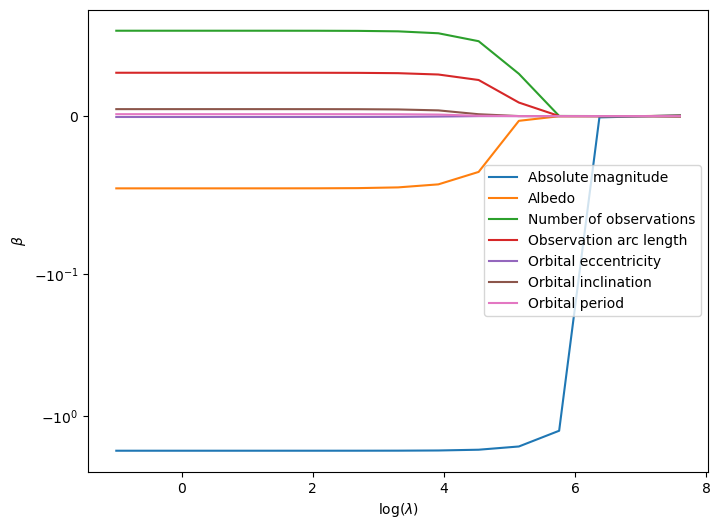

In [271]:
lambdas = np.logspace(-1, 7.6, 15)
log_lambdas = np.log10(lambdas)

N, p = X_train_std.shape
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)
beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train_diam)

beta_paths = np.vstack([
    minimise_g(X_train_std, y_train_diam, beta_ls_with_int, lam)
    for lam in lambdas
])
plt.figure(figsize=(8, 6))
for j, fn in enumerate(feature_names):
    plt.plot(log_lambdas, beta_paths[:, j], label=fn)

plt.xlabel(r"$\log(\lambda)$")
plt.ylabel(r"$\beta$")
plt.yscale("symlog",linthresh=0.1)
plt.legend()
plt.show()


The graph shows that as lambda becomes too large, all coefficients converge to 0 - as expected. As lambda increases, the 
$\lambda \sum_{j=1}^{p} |g_j|$ term starts to dominate the minimisation up to a point where our algorithm just minimises this part, making all gs equal to 0. 

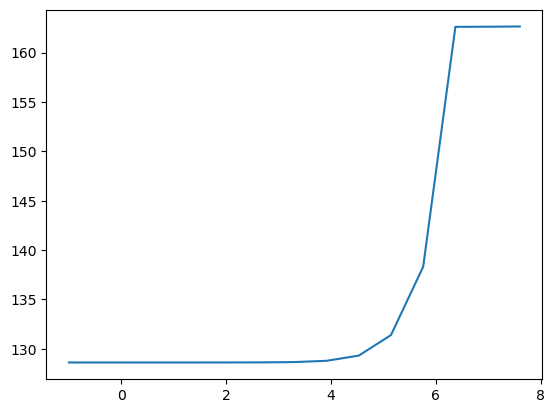

In [272]:
def MSE_t(X_train, y_train, X_val, y_val, lam):

    # Predict fitted values y_hat
    X_aug = add_int(X_train) # augmented training inputs of size N x (p+1)
    beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train)
    beta_g = minimise_g(X_train, y_train, beta_ls_with_int, lam)
    y_hat = fit_garrote(X_val, beta_g, beta_ls_with_int)

    # Compute MSE
    MSE = np.mean((y_hat - y_val)**2)

    return MSE

    
MSEs = np.array([ MSE_t(X_train_std, y_train_diam, X_test_std, y_test_diam, lam) for lam in lambdas])
min_lam = np.argmin(MSEs)

plt.figure()
plt.plot(log_lambdas, MSEs)


The graph above shows the MSE of the predictions of the test data plotted against different values of $\log(\lambda)$. It stays more or less the same for most values of $\lambda$ until it start to increase steeply. There is a clear cutoff at around 6, where the MSE becomes much larger, meaning that $\lambda$ is now too big. This means that a reasonable choice of lambda is anywhere within [-1, 6].

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [273]:
def D(full_X, full_y, T, lam):

    #Split X and Y into T folds
    N = len(full_y)
    fold_size = N // T
    MSEs = []

    for t in range(T):
        val_mask = np.zeros(N, dtype=bool)
        val_mask[t*fold_size:(t+1)*fold_size] = True
        X_val_not_std = full_X[val_mask]
        X_train_not_std = full_X[~val_mask]
        # Standardise validation first and then training set
        X_val = standardise(X_val_not_std, X_train_= X_train_not_std)
        X_train = standardise(X_train_not_std)
        y_train = full_y[~val_mask]
        y_val = full_y[val_mask]
        MSEs.append(MSE_t(X_train, y_train, X_val, y_val, lam))
    D = np.mean(np.abs(np.diff(np.array(MSEs))))

    return D

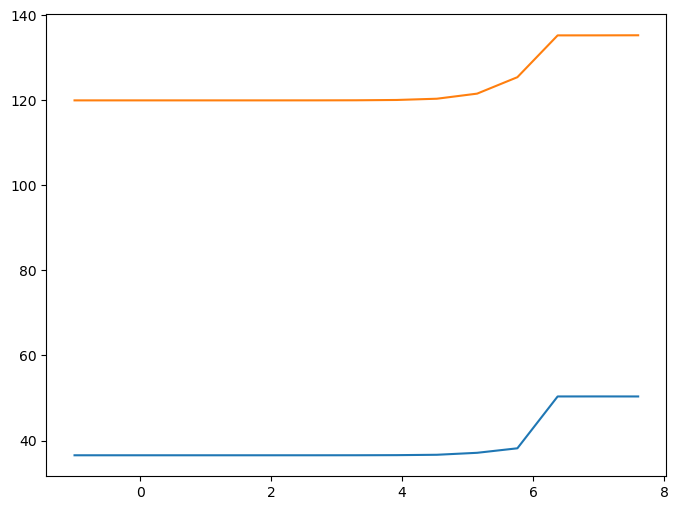

In [274]:
Ts = [2, 20]
Ds = []

for T in Ts:
    Ds.append([])
    for lam in lambdas:
        Ds[-1].append(D(X_train, y_train_diam, T, lam))

plt.figure(figsize=(8,6))
plt.plot(log_lambdas, Ds[0], label="T=2")
plt.plot(log_lambdas, Ds[1], label="T=20")


The graph suggests that as lambda becomes too high, D increases, hence the model becomes unstable. This makes sense, since for large values of lambda, the model prioritises shrinking the norm of the g vector, making hard, discontinuous feature-selection decisions, and those decisions can flip across folds, causing large jumps in validation MSE, thereby increasing D.

The difference between T = 2 and T = 20 is that the result is stronger for T = 20, since successive training sets differ only slightly, so the D is even more sensitive to small perturbations in the data. For T = 2 training sets differ substantially between folds, so these local instabilities are partially masked, resulting in a weaker increase in D.

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)
### Assessing LASSO feature selection stability via bootstrap

First, let's perform Lasso regression with the Huber function-based smoothing and compare results to 1.1.

In [275]:
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=5e-5, c_huber=1e-4):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression using the gradient-descent algorithm to find the optimal
    solution.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X
    Xy = X.T @ y
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Intercept term is not involved in the regularisation.
        grad_c[0] = 0 ## <-- EDIT THIS LINE

        # Compute the gradient of the regularised loss.
        grad =  2 * (XX @ beta - Xy) / N + lambd * grad_c ## <-- EDIT THIS LINE

        # Update beta
        beta -= step_size * grad ## <-- EDIT THIS LINE

    return beta

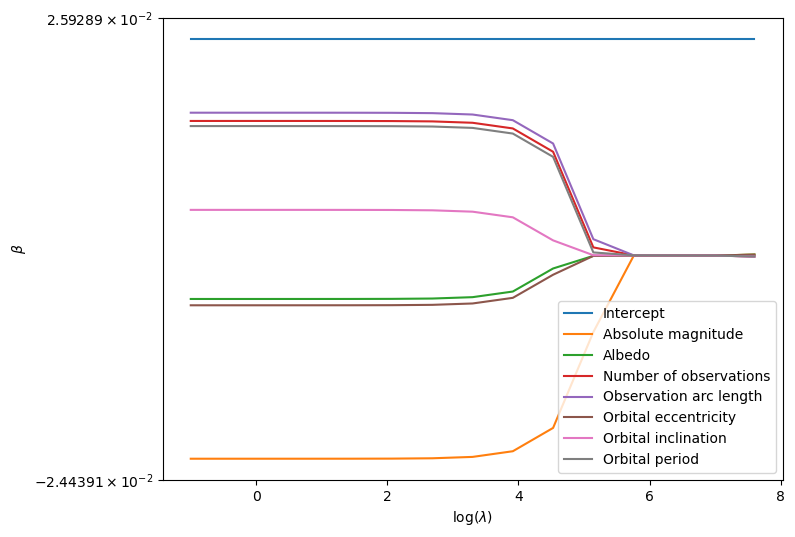

In [276]:
# Run LASSO regression for different lambdas

lasso_paths = np.vstack([
    minimize_ls_huber(X_aug, y_train_diam, lam, n_iters=10000,
                                step_size=1e-7,
                                c_huber=1e-4)
    for lam in lambdas
])

feature_names_with_int = ["Intercept"] + feature_names

plt.figure(figsize=(8, 6))
for j, fn in enumerate(feature_names_with_int):
    plt.plot(log_lambdas, lasso_paths[:, j], label=fn)

plt.xlabel(r"$\log(\lambda)$")
plt.ylabel(r"$\beta$")
plt.yscale("symlog",linthresh=0.1)
plt.legend()
plt.show()


The graph is similar to 1.1 in the sense that we also see all coefficients eventually going to zero, as lambda increases and the regularisation term starts dominating over least squares. The main difference is that the coefficients converge faster, implying that lambda has more weight here compared to Garotte. The predictors are consistent with 1.1 as well, with absolute magnitude being the biggest negative predictor, Albeido also being negative, but weaker in both, 

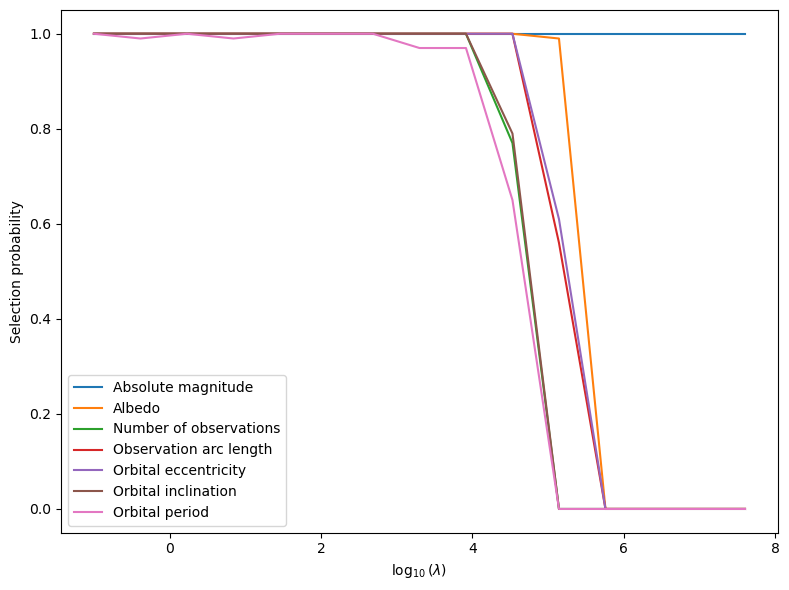

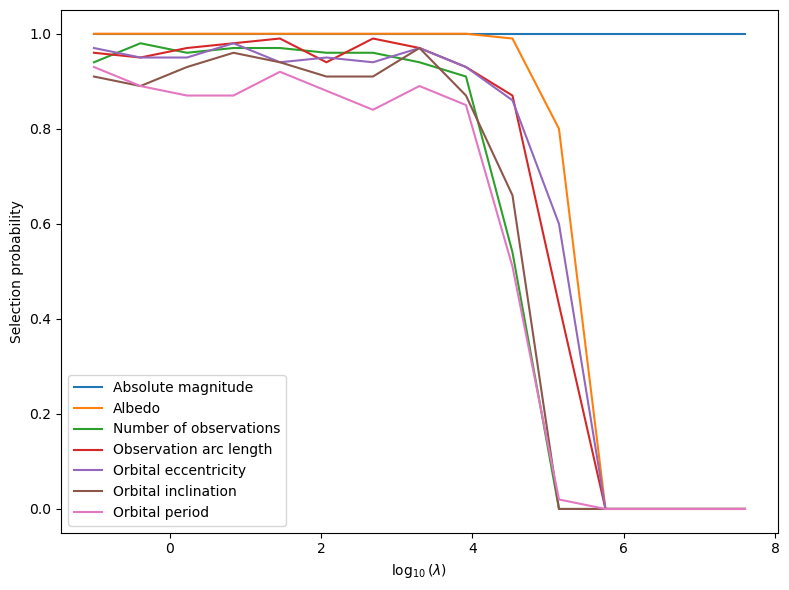

In [277]:
B = 100
N_dashes = [len(X_train_std) // 2, 50]
n = X_aug.shape[0]
prob_paths_Ns = []
for N_dash in N_dashes:
    prob_paths = []
    for lam in lambdas:

        features_bootstrap = []
        for i in range(B):
            idx = rng.choice(n, size=N_dash, replace=False)
            X_sample = X_aug[idx]
            y_sample = y_train_diam[idx]
            beta_lasso = minimize_ls_huber(X_sample, y_sample, lam, n_iters=10000,
                                        step_size=1e-7,
                                        c_huber=1e-4)
            feauters_selected = np.where(np.abs(beta_lasso) > 0.001, 1, 0)
            features_bootstrap.append(feauters_selected)
        feature_probabilities = np.array(features_bootstrap).mean(axis=0)
        prob_paths.append(feature_probabilities)
    prob_paths_Ns.append(prob_paths)

    prob_paths = np.array(prob_paths)  # (n_lambdas, n_features)

    plt.figure(figsize=(8, 6))

    for j, name in enumerate(feature_names):
        plt.plot(
            log_lambdas,
            prob_paths[:, j],
            label=name
        )

    plt.xlabel(r"$\log_{10}(\lambda)$")
    plt.ylabel("Selection probability")
    plt.legend()
    plt.tight_layout()
    plt.show()


Selection probability is the proportion of times our algorithm decided to include a feature (by not setting it's corresponding g value to 0, or almost zero - we use the threshold of 1e-3) in the regression - i.e. select it. In terms of feature selection stability, the selection probability tells us if a feature will still be selected if we perturb the data a little - features that were selected the most regardless of which bootstrap sample was used are more stable therefore.

Probability trajectories show, once again, that for large values of $\lambda$ all the features will end up not being selected. The steep change, once again, happenes at around $\lambda = 5$. 

(2, 15, 8)


<BarContainer object of 8 artists>

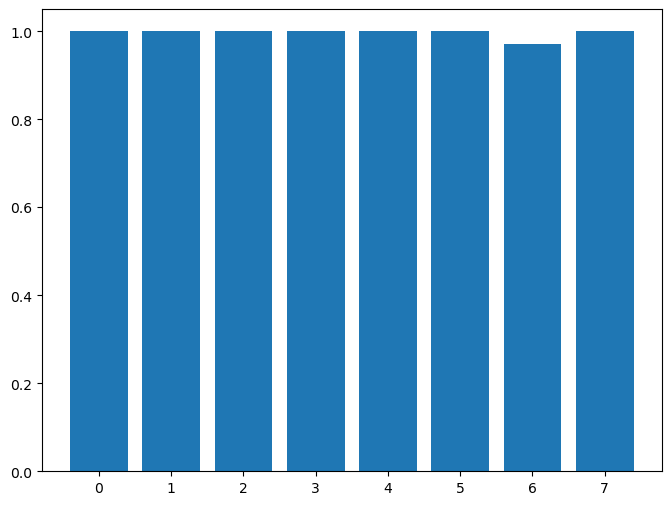

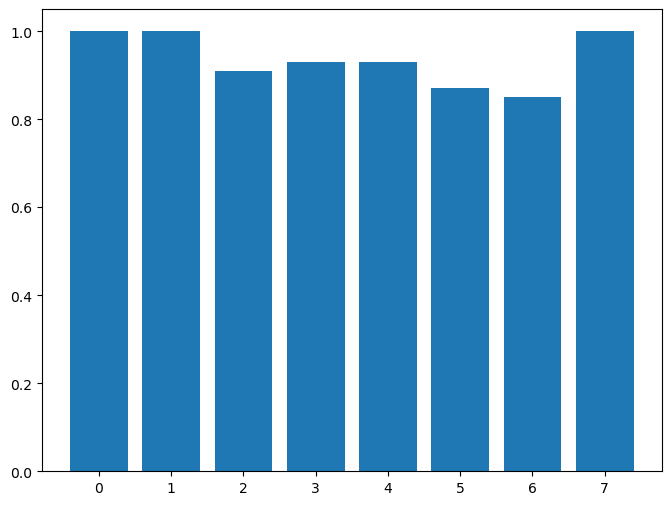

In [278]:
idx = 8
probs_arr = np.array(prob_paths_Ns)
print(probs_arr.shape)

probs_last_lambda = probs_arr[:, idx, :]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(8), probs_last_lambda[0])
plt.figure(figsize=(8, 6))
plt.bar(np.arange(8), probs_last_lambda[1])

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

<a name="task-2"></a>

# Task 2: Non-linear regression with Kernel Ridge Regression [(index)](#index-task-2)

In [279]:
def r_squared(y_hat, y):
    return 1 - np.sum((y_hat - y)**2) / np.sum((y - np.mean(y))**2)

def train_regression(X_train, y_train):
    X_train_aug = add_int(X_train)
    betas = max_lik_estimate(X_train_aug, y_train)
    return betas

def importance(X_test, y_test, feature, betas):
    X_test_aug = add_int(X_test)
    y_hat_baseline = X_test_aug @ betas
    r_squared_baseline = r_squared(y_hat_baseline, y_test)
    X_perm = X_test_aug.copy()
    X_perm[:, feature] = rng.permutation(X_perm[:, feature])
    y_hat_perm = X_perm @ betas
    r_squared_perm = r_squared(y_hat_perm, y_test)

    return np.abs(r_squared_baseline - r_squared_perm)   



<BarContainer object of 8 artists>

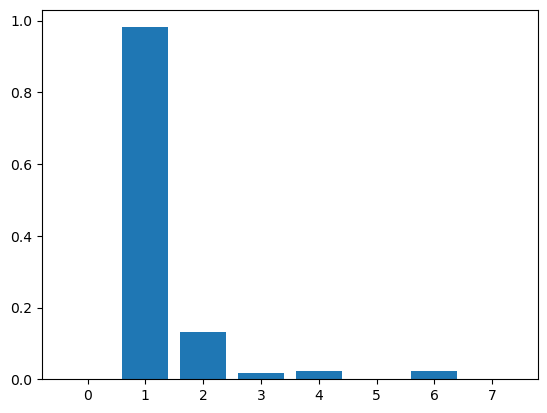

In [280]:
# Train Ordinary Least Squares Regression on Training data
ols_betas = train_regression(X_train_std, y_train_diam)
p = X_test_std.shape[1] + 1
feature_imp = np.array([
    importance(X_test_std, y_test_diam, feature, ols_betas)
    for feature in range(p)
])
plt.bar(np.arange(0,p,1), feature_imp)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

In [281]:
# From Week 2 notebook
def ridge_estimate(X, y, penalty):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters ((p + 1) x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    X_aug = add_int(X) # augmented training inputs of size N x (p + 1)
    N_aug, p_aug = X_aug.shape
    I = np.identity(p_aug)
    I[0] = 0.0 # penalty excludes the bias term.
    beta_ridge = np.linalg.inv(X_aug.T @ X_aug + penalty * np.eye(p_aug)) @ X_aug.T @ y
    return beta_ridge

def fit_ridge(X_train, y_train, penalty, X_test):
    X_test_aug = add_int(X_test)
    betas = ridge_estimate(X_train, y_train, penalty)
    y_hat = X_test_aug @ betas
    return y_hat



y_fitted_train = fit_ridge(X_train_std, y_train_diam, 0.1, X_train_std)
y_fitted_test = fit_ridge(X_train_std, y_train_diam, 0.1, X_test_std)
print(r_squared(y_fitted_train, y_train_diam), r_squared(y_fitted_test, y_test_diam))

0.756284223512813 0.7363169499385698


### Kernalised Ridge Regression.

We use $$ k^{p}(v, z) = (v \cdot z + c)^{n} $$ as our kernel. We now need to derive the Gram matrix K. From lecture notes we know that

$ K_{ij} = k^p(x_i, x_j)$, where $x_i, x_j$ are rows of the data metrix X.

Having obtained the Gram matrix, we can derive the formula for new optimal regressors $\beta_k$ explicitly, by constructing the loss function and computing it's gradient:
$$
\mathcal{L}(\beta_k)
= \frac{1}{n}\,\|y - K\beta_k\|^2 + \lambda\, \beta_k^{\top} K \beta_k
$$

$$
\nabla \mathcal{L}(\beta_k)
= \frac{2}{n_{train}}\bigl(K^{\top}K\beta_k - K^{\top}y\bigr) + 2\lambda K\beta_k = 0
$$

$$
\hat{\beta}_k
= \left(K^{\top}K + \lambda n_{train} K\right)^{-1} K^{\top} y
$$

$$
= \left(K^{2} + n_{train}\lambda K\right)^{-1} K y
$$

$$
= \left(K + n_{train}\lambda I\right)^{-1} y,
$$
$$
\text{since } K = K^{\top}.
$$

Now, let's make predictions:
$$
\hat{y} = K\beta_k
$$



In [282]:
def Gram(x, y, c, n):
    return (x @ y.T + c) ** n

def beta_krr(X_train, y_train, lam, K):
    n_train = X_train.shape[0]
    betas = np.linalg.inv(K + n_train*lam*np.eye(n_train)) @ y_train
    return betas
    

In [283]:
def performance_n_c(X_train, y_train, X_test, y_test, n, c):
    K_train = Gram(X_train, X_train, c, n)
    K_test = Gram(X_test, X_train, c, n)
    betas_k = beta_krr(X_train, y_train, 0.1, K_train)
    r_squared_train = r_squared(K_train @ betas_k, y_train)
    r_squared_test = r_squared(K_test @ betas_k, y_test)
    print(f"n = {n}, c = {c}: Train R^2 = {r_squared_train}, Test R^2 = {r_squared_test}")

performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 2, 0)
performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 2, 1)
performance_n_c(X_train_std, y_train_diam, X_test_std, y_test_diam, 3, 1)

n = 2, c = 0: Train R^2 = 0.744277295023313, Test R^2 = 0.6175788574986535
n = 2, c = 1: Train R^2 = 0.953255587713263, Test R^2 = 0.947743591512433
n = 3, c = 1: Train R^2 = 0.9843306895540649, Test R^2 = 0.975992926426917


Kernels are great.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In [284]:
def poly_kernel(x, y):
    return (x @ y.T + 1)**2

def radial_kernel(x, y, sigma=20):
    x_sq = np.sum(x**2, axis=1)[:, None]   # (n_x, 1)
    y_sq = np.sum(y**2, axis=1)[None, :]   # (1, n_y)
    return np.exp(-(x_sq - 2.0 * (x @ y.T) + y_sq) / sigma)

def new_kernel(x, y, sigma=20):
    Kxy = poly_kernel(x, y)  # (n_x, n_y)

    # Diagonal terms: k(x_i, x_i) and k(y_j, y_j)
    xx_diag = np.diag(poly_kernel(x, x))  # (n_x,)
    yy_diag = np.diag(poly_kernel(y, y))  # (n_y,)

    # Squared distances in feature space:
    # ||phi(x_i)-phi(y_j)||^2 = k(x_i,x_i) - 2k(x_i,y_j) + k(y_j,y_j)
    D = xx_diag[:, None] - 2.0 * Kxy + yy_diag[None, :]
    return np.exp(- D / sigma)

def kernel_performance(kernel, X_train, y_train, lam=0.1):
    gram = kernel(X_train, X_train)
    betas = beta_krr(X_train, y_train, 300, gram)
    r_sqr = r_squared(gram @ betas, y_train)
    print(f"{kernel} R^2: {r_sqr}")

In [285]:
X_reduced = X_train_std[:, :2]

kernel_performance(poly_kernel, X_reduced, y_train_diam)
kernel_performance(radial_kernel, X_reduced, y_train_diam)
kernel_performance(new_kernel, X_reduced, y_train_diam)


<function poly_kernel at 0x14fbfc360> R^2: -0.7456085793543004
<function radial_kernel at 0x14fbfc9a0> R^2: -0.7803514683772905
<function new_kernel at 0x14efec2c0> R^2: -0.7820365661651816


(638, 2)


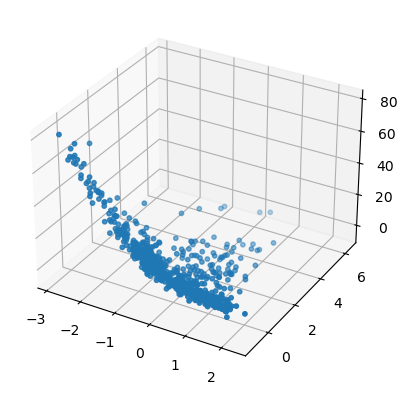

In [286]:
print(X_reduced.shape)
gram = poly_kernel(X_train, X_train)
betas = beta_krr(X_train, y_train_diam, 300, gram)
y_pred = gram @ betas
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y_pred, s=10)

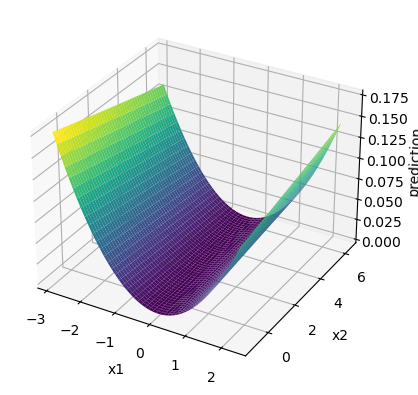

In [287]:
x1_min, x1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
x2_min, x2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 50),
    np.linspace(x2_min, x2_max, 50)
)
X_grid = np.column_stack([xx1.ravel(), xx2.ravel()])
K_grid = poly_kernel(X_grid, X_train[:, :2])
y_grid = K_grid @ betas
Z = y_grid.reshape(xx1.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(xx1, xx2, Z, cmap="viridis")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("prediction")

plt.show()

<a name="task-3"></a>

# Task 3: Classification with the Multi-Layer Perceptron [(index)](#index-task-3)

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Weights $\mathbf{W}^{(0)} \in\mathbb{R}^{64 \times 8}$
* Bias $\mathbf{b}^{(0)} \in\mathbb{R}^{64}$

First hidden layer -> second hidden layer:
* Weights $\mathbf{W}^{(l)} \in\mathbb{R}^{64\times 64}$, $l=1, 2$
* Bias $\mathbf{b}^{(l)} \in\mathbb{R}^{64}$, $l=1, 2$

Second hidden layer -> third hidden layer:
* Weights $\mathbf{W}^{(l)} \in\mathbb{R}^{32\times 64}$, $l=1, 2$
* Bias $\mathbf{b}^{(l)} \in\mathbb{R}^{32}$, $l=1, 2$

Third hidden layer -> output layer:
* Weights $\mathbf{W}^{(3)} \in\mathbb{R}^{3 \times 32}$
* Bias $\mathbf{b}^{(3)} \in\mathbb{R}^{3}$

We will create these parameters as numpy arrays, and initialise the weights values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

In [357]:
# All the functions in this cell are imported from MLP notebook

def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in is the input dimension.
        W (np.ndarray): h_out x h_in array for weights matrix parameters, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = X @ W.T + b
    return a

def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.maximum(a, 0.)  ## <-- EDIT THIS LINE
    return h

def identity(x):
    return x

## EDIT THIS FUNCTION
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    return (a > 0).astype(float)

var0 = 2. / (64 + 8)
W0 = rng.normal(size=(64, 8)) * np.sqrt(var0)
b0 = np.zeros(64)

var1 = 2. / (64 + 64)
W1 = rng.normal(size=(64, 64)) * np.sqrt(var1)
b1 = np.zeros(64)

var2 = 2. / (32 + 64)
W2 = rng.normal(size=(32, 64)) * np.sqrt(var2)
b2 = np.zeros(64)

var3 = 2. / (3 + 32)
W3 = rng.normal(size=(3, 32)) * np.sqrt(var3)
b3 = np.zeros(1)

def mlp_3layers(X):
    """MLP with 3 hidden layers and ReLU activation

    Parameters:
        X: K x 8 array of inputs

    Returns:
        y:  K x 1 output array
    """
    if X.ndim == 1:
        # If one example passed, add a dummy dimension for the batch.
        X = X.reshape(1, -1)

    # compose 3-layer MLP
    h = X
    a = dense(h, W0, b0)
    h = relu_activation(a)

    a = dense(h, W1, b1)
    h = relu_activation(a)

    a = dense(h, W2, b2)
    h = relu_activation(a)
    y = dense(h, W3, b3)

    return y

# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}

class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            # hint: use self.rng.normal()
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (out_dim + in_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            "activation": activation
            })

    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)

        forward_pass = []
        h = X  # this is what gets updated layer-by-layer

        for k in range(len(self.layers)):
            # pre-activation
            a = dense(h, self.layers[k]["W"], self.layers[k]["b"])
            activation = activation_table[self.layers[k]["activation"]]

            # post-activation
            h_next = activation(a)

            forward_pass.append({"index": k, "a": a, "h": h})  # h = input to this layer
            h = h_next

        y_hat = h  # output of last layer after its activation
        return y_hat, forward_pass



In [358]:
def cross_entropy_loss(y, p):
    """
    Cross-entropy loss.

    Parameters:
    y_true : np.ndarray, shape (N, 3)
        One-hot encoded true labels.
    p_pred : np.ndarray, shape (N, 3)
        Predicted class probabilities.
    eps : float
        Small constant for numerical stability.

    Returns:
    loss : float
        Cross-entropy loss (mean over samples).
    """
    loss = -np.sum(y * np.log(p), axis=1)
    return np.mean(loss)


def softmax(a):
    """
    Numerically stable softmax.

    Parameters:
    a : np.ndarray, shape (N, 3)
        Logits (pre-activations).

    Returns:
    p : np.ndarray, shape (N, 3)
        Softmax probabilities.
    """
    a_shifted = a - np.max(a, axis=1, keepdims=True)
    exp_a = np.exp(a_shifted)
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def ce_grad(y, p):
    return y - p

In [359]:
import numpy as np

def backpropagate(layers, forward_pass, delta_output):
    """
    Backprop through MLP layers.

    layers: list of dicts with keys at least ["index","W","b","activation"]
            W shape (h_out, h_in), b shape (h_out,)
    forward_pass: list of dicts with keys at least ["index","h","a"]
            h shape (K, h_in), a shape (K, h_out)
    delta_output: dL/dh_out (or dL/da_out depending on your setup), shape (K, h_out)
    """
    gradients = []
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers must match forward pass length."

    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"] # (K, h_in)
        a = forward_computes["a"] # (K, h_out)
        W = layer["W"] # (h_out, h_in)

        K = h.shape[0]
        assert delta.shape[0] == K, "Mismatch in the batch dimension."
        assert W.shape[1] == h.shape[1], "W and h shapes incompatible."

        # derivative of activation for this layer
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(a) # (K, h_out)

        # delta w.r.t pre-activations a: (K, h_out)
        delta_a = delta * grad_activation

        # average gradients over batch
        dW = (delta_a.T @ h) / K # (h_out, h_in)
        db = np.mean(delta_a, axis=0) # (h_out,)

        gradients.append({"W": dW, "b": db})

        # propagate to previous layer: dL/dh_prev (K, h_in)
        delta = delta_a @ W

    gradients = list(reversed(gradients))
    return gradients


In [366]:
def sgd_step(X, y, mlp, learning_rate=1e-3):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)  ## <-- EDIT THIS LINE

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    # For softmax + cross-entropy: dL/dlogits = (y_hat - y)/K
    delta_output = (y_hat - y) / X.shape[0]  ## <-- EDIT THIS LINE

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)  ## <-- SOLUTION.

    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]  ## <-- EDIT THIS LINE
        b = layer["b"] - learning_rate * grad["b"]  ## <-- EDIT THIS LINE
        updated_layers.append({
            "W": W, "b": b,
            "activation": layer["activation"],
            "index": layer["index"]
        })

    return updated_layers

def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    for i in range(n_epochs):

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate=learning_rate)

            mlp.layers = updated_layers

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        loss_train = cross_entropy_loss(y_train, y_hat_train).squeeze()
        losses_train.append(loss_train)
        y_hat_test, _ = mlp.predict(X_test)
        loss_test = cross_entropy_loss(y_test, y_hat_test).squeeze()
        losses_test.append(loss_test)

        if (i==0) or ((i+1)%50==0):
          print(
              f'Epoch {i+1}/{n_epochs}: In-sample error: {loss_train}, Out-of-sample error: {loss_test},'
              f'train R^2: {r2_score(y_train, y_hat_train):.2f}, test R^2: {r2_score(y_test, y_hat_test):.2f}.'
               )

    return mlp, losses_train, losses_test


In [367]:
# Training MLP
mlp = MLP(seed=2)
mlp.add_layer(X_train_std.shape[1], 64, "identity")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 32, "relu")
mlp.add_layer(32, 3, "identity")
y_train_oh = np.eye(3)[y_train_class_int]
y_test_oh  = np.eye(3)[y_test_class_int]
mlp, losses_train, losses_test = sgd(X_train_std, y_train_oh, X_test_std, y_test_oh, mlp, learning_rate = 0.04,
        n_epochs=500, minibatchsize=64, seed=42)


/var/folders/z9/c4qhll5j4d1_vdj8tbv7xnfw0000gn/T/ipykernel_47845/2316756778.py:17: RuntimeWarning: invalid value encountered in log
  loss = -np.sum(y * np.log(p), axis=1)


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [365]:
print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)

print("Layer 0 W shape:", mlp.layers[0]["W"].shape)
print("Layer 1 W shape:", mlp.layers[1]["W"].shape)

X_train_std shape: (638, 7)
X_test_std shape: (160, 7)
Layer 0 W shape: (64, 7)
Layer 1 W shape: (64, 64)


<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)